Importing the Sight Dataset and the Coursera Review Dataset and Preprocessing/Cleaning them

In [ ]:
!pip install transformers langdetect unidecode torch

In [ ]:
import pandas as pd

coursera_df = pd.read_csv("https://raw.githubusercontent.com/Sriva29/bert-learning-analytics/refs/heads/main/data/reviews_by_course.csv")
coursera_df.head()

,CourseId,Review,Label
0,2-speed-it,BOring,1
1,2-speed-it,Bravo !,5
2,2-speed-it,Very goo,5
3,2-speed-it,"Great course - I recommend it for all, especia...",5
4,2-speed-it,One of the most useful course on IT Management!,5


In [ ]:
#Inspecting the data types and checking if there are any missing values
print(coursera_df.info())
print(coursera_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140320 entries, 0 to 140319
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   CourseId  140320 non-null  object
 1   Review    140317 non-null  object
 2   Label     140320 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 3.2+ MB
None
CourseId    0
Review      3
Label       0
dtype: int64


In [ ]:
# Since only 3 missing values, dropping them
coursera_df = coursera_df.dropna(subset=["Review"])
print(coursera_df.isnull().sum())

CourseId    0
Review      0
Label       0
dtype: int64


In [ ]:
#Checking label distribution
print(coursera_df["Label"].value_counts())

Label
5    106514
4     22460
3      5923
1      2866
2      2554
Name: count, dtype: int64


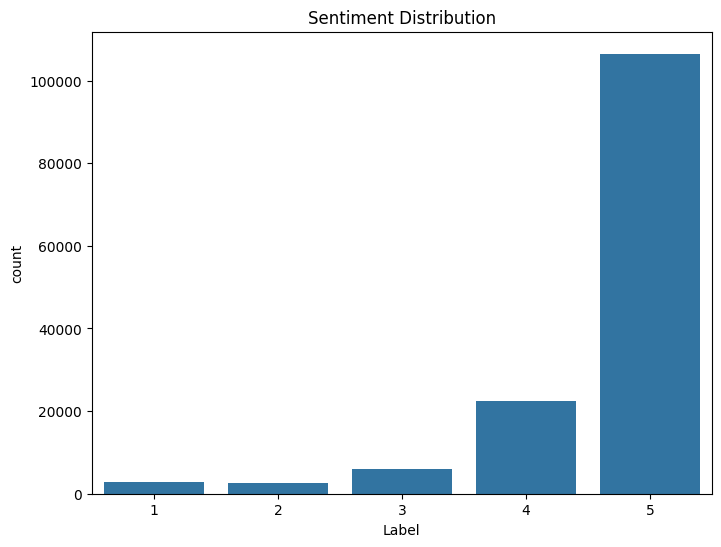

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.countplot(x='Label', data=coursera_df)
plt.title('Sentiment Distribution')
plt.show()

In [ ]:
'''At this point, given that the dataset is skewed with a lot more rows labelled 5 than not, given the choice of undersampling label 5, oversampling the lower labels 1-4,
and using class weights, we decided to go with class weights to avoid artificially adding data (fake reviews) to the dataset.
'''

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

#Defining the classes and their freq

classes = sorted(coursera_df["Label"].unique())
print(classes)
classes = np.array(classes)
class_weights = compute_class_weight(
    class_weight = "balanced",
    classes = classes,
    y=coursera_df["Label"]
)

#Converting to dictionary for easy ref
class_weights_dict = {classes[i]: class_weights[i] for i in range(len(classes))}
print(class_weights_dict)


[1, 2, 3, 4, 5]
{1: 9.791835310537333, 2: 10.988018794048552, 3: 4.738038156339693, 4: 1.2494835262689226, 5: 0.26347146853934694}


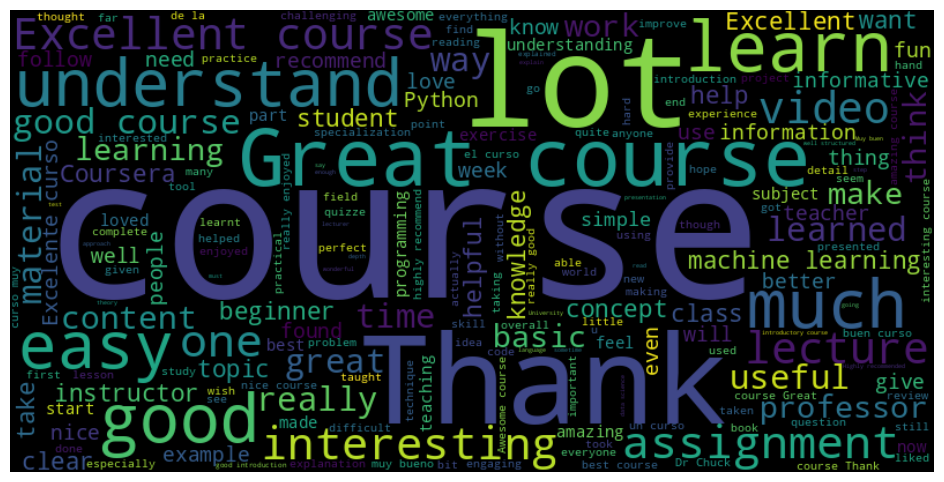

In [ ]:
from wordcloud import WordCloud
text = ' '.join(coursera_df['Review'])
wordcloud = WordCloud(width=800, height=400).generate(text)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Upon visual inspection of the dataset, we noticed some issues:

1. Non-English Reviews: Some of the reviews are in spanish. In BERT is pre-trained on English text, this will cause problems and affect fine-tuning quality.
2. Gibberish and Encoding issues: We found that some of the reviews had plain gibberish text. eg: Ð”Ð¾ÑÑ‚ÑƒÐ¿Ð½Ð¾ Ð¸ Ð¸Ð½Ñ‚ÐµÑ€ÐµÑÐ½Ð¾. We will either correct the encoding errors or drop them.

In [ ]:
# install langdetect and unidecode

from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException
def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return "unknown"

#Detecting each review language
coursera_df["Language"] = coursera_df["Review"].apply(detect_language)

#filtering only English reviews
english_reviews_df = coursera_df[coursera_df["Language"]=="en"]

print(english_reviews_df["Language"].value_counts())
english_reviews_df.head()

Language
en    106911
Name: count, dtype: int64


,CourseId,Review,Label,Language
3,2-speed-it,"Great course - I recommend it for all, especia...",5,en
4,2-speed-it,One of the most useful course on IT Management!,5,en
5,2-speed-it,I was disappointed because the name is mislead...,3,en
6,2-speed-it,Super content. I'll definitely re-do the course,5,en
8,2-speed-it,One of the excellent courses at Coursera for i...,5,en


In [ ]:
#Fixing giberrish

from unidecode import unidecode

english_reviews_df["cleaned_review"] = english_reviews_df["Review"].apply(unidecode)

print(english_reviews_df["cleaned_review"].head())
print(english_reviews_df.shape)


3    Great course - I recommend it for all, especia...
4      One of the most useful course on IT Management!
5    I was disappointed because the name is mislead...
6      Super content. I'll definitely re-do the course
8    One of the excellent courses at Coursera for i...
Name: cleaned_review, dtype: object
(106872, 5)


<ipython-input-9-45dfe064e1bc>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_reviews_df["cleaned_review"] = english_reviews_df["Review"].apply(unidecode)


In [ ]:
#Checking whether original df had more langs

print(coursera_df["Language"].value_counts())



Language
en         106872
es          12260
fr           3608
zh-cn        2336
pt           2240
ro           2095
ca           1990
af           1553
ru           1531
so            983
de            772
it            548
no            416
ko            327
tl            314
sw            270
cy            256
id            224
unknown       206
vi            184
nl            183
pl            167
sl            158
da            138
cs             83
sk             80
et             79
sq             70
sv             47
zh-tw          45
tr             44
fi             38
hu             37
hr             32
bg             30
lt             28
uk             16
mk             14
lv             14
he             11
ar             10
fa              4
ja              2
ur              1
el              1
Name: count, dtype: int64


In [ ]:
# Saving new csv
import os
os.makedirs("data", exist_ok=True)

english_reviews_df.to_csv("data/coursera_english_reviews.csv", index=False)


Now that we only have English reviews, time to apply standard text preprocessing such as conversion to lowercase, punctuation removal, special character removal, and extra whitespace removal

In [ ]:
import re

# Text cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Applying cleaning to the Review column
english_reviews_df["cleaned_review"] = english_reviews_df["Review"].apply(clean_text)

# Verifying the changes
print(english_reviews_df[["Review", "cleaned_review"]].head())

                                              Review  \
3  Great course - I recommend it for all, especia...   
4    One of the most useful course on IT Management!   
5  I was disappointed because the name is mislead...   
6    Super content. I'll definitely re-do the course   
8  One of the excellent courses at Coursera for i...   

                                      cleaned_review  
3  great course i recommend it for all especially...  
4     one of the most useful course on it management  
5  i was disappointed because the name is mislead...  
6       super content ill definitely redo the course  
8  one of the excellent courses at coursera for i...  


<ipython-input-18-cb3b9402fbce>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_reviews_df["cleaned_review"] = english_reviews_df["Review"].apply(clean_text)


In [ ]:
# Spliting the data
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(english_reviews_df, test_size=0.2, stratify=english_reviews_df["Label"], random_state=37)

print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")

Training set size: 85528
Validation set size: 21383


Tokenizing using BERT from Hugging Face Transformers library

In [ ]:
# Analyzing dataset to determine max_length for BERT tokenization
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

review_lengths = english_reviews_df["cleaned_review"].apply(lambda x: len(tokenizer.tokenize(x)))
print(review_lengths.describe())  # Check mean, median, and max token length


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

count    106911.000000
mean         26.531470
std          34.925301
min           1.000000
25%           8.000000
50%          16.000000
75%          33.000000
max        1425.000000
Name: cleaned_review, dtype: float64


In [ ]:
print(english_reviews_df.columns)

Index(['CourseId', 'Review', 'Label', 'Language', 'cleaned_review'], dtype='object')


In [ ]:
#Verifying GPU usage
import torch

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA version:", torch.version.cuda)
    print("GPU:", torch.cuda.get_device_name(0))


PyTorch version: 2.0.1+cu117
CUDA available: True
CUDA version: 11.7
GPU: Tesla T4


In [ ]:
from transformers import BertTokenizer

# Load a tokenizer to test
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
print("Transformers library is functional!")


Transformers library is functional!


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
# Given that token lenght rarely even touches 128, we will keep max_lenght as 128
import torch
def tokenize_data(data):
    return tokenizer(
        list(data["cleaned_review"]),
        padding = True,
        truncation = True,
        max_length = 128,
        return_tensors="pt"
    )

train_encodings = tokenize_data(train_data)
val_encodings = tokenize_data(val_data)

print("Tokenization has been completed!")


Tokenization has been completed!


## BERT Fine Tuning

In [ ]:
# Convert labels to tensors
train_labels = torch.tensor(train_data["Label"].values)
val_labels = torch.tensor(val_data["Label"].values)


In [ ]:
from torch.utils.data import Dataset

# Define PyTorch Dataset class
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.encodings["input_ids"][idx],
            "attention_mask": self.encodings["attention_mask"][idx],
            "labels": self.labels[idx]
        }

# Create dataset objects
train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)

print("Datasets created successfully!")


Datasets created successfully!


In [ ]:
from torch.utils.data import DataLoader

# Set batch size (adjust as needed based on GPU memory)
batch_size = 16

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders are ready!")


DataLoaders are ready!


In [ ]:
from transformers import BertForSequenceClassification

# Load pretrained BERT model with 5 output labels (for star ratings 1-5)
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=5)

# Move model to GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

print("BERT model loaded and moved to device:", device)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERT model loaded and moved to device: cuda


In [ ]:
from transformers import AdamW

# Set optimizer with weight decay (helps with regularization)
optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)

# Define loss function (cross-entropy with class weights)
from torch.nn import CrossEntropyLoss

# Convert class weights to a tensor with dtype float32
class_weights_tensor = torch.tensor(list(class_weights_dict.values()), dtype=torch.float32).to(device)

# Define the loss function with class weights
loss_function = CrossEntropyLoss(weight=class_weights_tensor)


print("Optimizer and loss function ready!")


Optimizer and loss function ready!


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [40]:
# Shift labels to be 0-indexed and ensure they are within the expected range (0-4)
train_data["Label"] = (train_data["Label"] - 1).clip(0, 4)  # Shift and clip in one step
val_data["Label"] = (val_data["Label"] - 1).clip(0, 4)    # Shift and clip in one step

train_labels = torch.tensor(train_data["Label"].values, dtype=torch.long)  # Now use shifted labels
val_labels = torch.tensor(val_data["Label"].values, dtype=torch.long)

train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [42]:
from transformers import get_scheduler

# Ensure class labels are shifted before creating DataLoader
train_labels = torch.tensor(train_data["Label"].values - 1, dtype=torch.long)
val_labels = torch.tensor(val_data["Label"].values - 1, dtype=torch.long)

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
print("Min label:", train_labels.min().item(), "Max label:", train_labels.max().item())

# Define learning rate scheduler
epochs = 3
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * epochs
)

# Training function
def train(model, train_loader, val_loader, optimizer, loss_function, scheduler, device, epochs=3):
    model.train()

    for epoch in range(epochs):
        total_loss, total_correct = 0, 0

        for batch in train_loader:
            optimizer.zero_grad()

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask).logits
            loss = loss_function(outputs, labels)

            # Compute accuracy
            predictions = torch.argmax(outputs, dim=1)
            total_correct += (predictions == labels).sum().item()

            # Backward pass
            loss.backward()
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        accuracy = total_correct / len(train_loader.dataset)

        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

    print("Training complete!")

# Run training
train(model, train_loader, val_loader, optimizer, loss_function, lr_scheduler, device, epochs=3)


Min label: -1 Max label: -1


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
